In [1]:
import pandas as pd
import numpy as np
from plotnine import (
    ggplot,
    aes,
    geom_density,
    facet_wrap,
    theme_bw,
    labs,
    theme,
    geom_vline,
)
from sklearn.model_selection import train_test_split
from funs import dataPreparation, createMetaDictionary, createDictionary, evaluateModel

# Data preparation

In [2]:
data = dataPreparation(
    all_trxns_path="../data/all_trxns.csv", exchange_rates_path="../data/exchange_rates.csv"
)

X = data
y = data["fraud_flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

c:\Users\mateu\Desktop\new folder\fraud-pred\Fraud-Prediction\src\funs.py:182: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


# Fraud probability dictionaries model

This approach tailored to fraud detection through statistical analysis and rule-based flagging, relying on the assumption that certain statistical patterns in the data can be indicative of fraudulent activity.

In [3]:
dictionaries_to_get = [
    "customer_country",
    "counterparty_country",
    "type",
    "ccy",
    "customer_type",
    "weekday",
    "month",
    "quarter",
    "hour",
    "amount_eur_bucket",
]

## Check historical fraud probability for each value of each variable

In [4]:
dictionaries = {}
for dict_name in dictionaries_to_get:
    dictionaries[dict_name] = createDictionary(
        X_train, colname=dict_name, count_filter=0
    )

## Define the limits for the historical fraud probability for each variable

In [5]:
meta_dicts = []  # Use a list to collect dictionaries
for dict_name in dictionaries_to_get:
    meta_dict = createMetaDictionary(X_train, colname=dict_name, quantile_threshold=0.9, count_filter=0)
    meta_dicts.append(meta_dict)

In [6]:
meta_dictionary = pd.concat(meta_dicts, ignore_index=True)

## Model
1. Join and transform the data
    - Train Input Data
    - Dictionaries
    - Meta Dictionary
2. Compare training set fraud probability with Meta Dictionary thresholds for standard deviation and quantile flags
3. Aggregate to transaction level and sum the probabilities and the flags

In [7]:
joined_data_test = (
    X_train.merge(dictionaries["customer_country"], on="customer_country", how="left")
    .merge(dictionaries["counterparty_country"], on="counterparty_country", how="left")
    .merge(dictionaries["type"], on="type", how="left")
    .merge(dictionaries["ccy"], on="ccy", how="left")
    .merge(dictionaries["customer_type"], on="customer_type", how="left")
    .merge(dictionaries["weekday"], on="weekday", how="left")
    .merge(dictionaries["month"], on="month", how="left")
    .merge(dictionaries["quarter"], on="quarter", how="left")
    .merge(dictionaries["hour"], on="hour", how="left")
    .merge(dictionaries["amount_eur_bucket"], on="amount_eur_bucket", how="left")
    .loc[
        :,
        [
            "timestamp",
            "customer",
            "customer_country",
            "customer_type",
            "counterparty",
            "counterparty_country",
            "type",
            "ccy",
            "amount_eur_bucket",
            "weekday",
            "month",
            "quarter",
            "hour",
            "customer_country_value",
            "counterparty_country_value",
            "type_value",
            "ccy_value",
            "customer_type_value",
            "weekday_value",
            "month_value",
            "quarter_value",
            "hour_value",
            "amount_eur_bucket_value",
        ],
    ]
)

joined_data_test = (
    joined_data_test.melt(
        id_vars=[
            "timestamp",
            "customer",
            "counterparty",
            "customer_country",
            "counterparty_country",
            "type",
            "ccy",
            "amount_eur_bucket",
            "weekday",
            "month",
            "quarter",
            "hour",
            "customer_type",
        ],
        value_vars=[
            "customer_country_value",
            "counterparty_country_value",
            "type_value",
            "ccy_value",
            "customer_type_value",
            "weekday_value",
            "month_value",
            "quarter_value",
            "hour_value",
            "amount_eur_bucket_value",
        ],
    )
    .assign(name=lambda x: x["variable"].str.replace("_value", ""))
    .merge(meta_dictionary, left_on="name", right_on="variable_name")
    .drop(columns=["variable_name", "variable"])
)

joined_data_test_aggregated = (
    joined_data_test.assign(sd_flag=lambda x: np.where(x["value"] > x["sd_flag"], 1, 0))
    .assign(quantile_flag=lambda x: np.where(x["value"] > x["q_flag"], 1, 0))
    .assign(quantile_1_flag=lambda x: np.where(x["value"] > x["q_1_flag"], 1, 0))
    .assign(quantile_25_flag=lambda x: np.where(x["value"] > x["q_25_flag"], 1, 0))
    .assign(quantile_75_flag=lambda x: np.where(x["value"] > x["q_75_flag"], 1, 0))
    .assign(quantile_9_flag=lambda x: np.where(x["value"] > x["q_9_flag"], 1, 0))
    .drop_duplicates(["timestamp", "customer", "counterparty", "name"])
    .groupby(
        [
            "timestamp",
            "customer",
            "counterparty",
            "customer_country",
            "counterparty_country",
            "type",
            "ccy",
            "amount_eur_bucket",
            "weekday",
            "month",
            "quarter",
            "hour",
            "customer_type",
        ]
    )
    .agg(
        expected_fraud_probability=("value", "sum"),
        sd_flags=("sd_flag", "sum"),
        quantile_flags=("quantile_flag", "sum"),
        quantile_1_flags=("quantile_1_flag", "sum"),
        quantile_25_flags=("quantile_25_flag", "sum"),
        quantile_75_flags=("quantile_75_flag", "sum"),
        quantile_9_flags=("quantile_9_flag", "sum"),
    )
    .reset_index()
)

model_formula = joined_data_test_aggregated.assign(
    predicted_fraud=np.where(
        (joined_data_test_aggregated["expected_fraud_probability"] > 0.15)
        & (joined_data_test_aggregated["sd_flags"] > 1)
        & (joined_data_test_aggregated["quantile_flags"] > 1)
        & (joined_data_test_aggregated["quantile_9_flags"] > 2),
        1,
        0,
    )
)

joined_data_aggregated = X_train[
    [
        "timestamp",
        "customer",
        "counterparty",
        "customer_country",
        "counterparty_country",
        "type",
        "ccy",
        "amount_eur_bucket",
        "fraud_flag",
        "weekday",
        "month",
        "quarter",
        "hour",
        "customer_type",
    ]
].merge(
    model_formula,
    on=[
        "timestamp",
        "customer",
        "counterparty",
        "customer_country",
        "counterparty_country",
        "type",
        "ccy",
        "amount_eur_bucket",
        "weekday",
        "month",
        "quarter",
        "hour",
        "customer_type",
    ],
    how="left",
)

joined_data_aggregated = joined_data_aggregated.assign(
    fraud_flag_transformed=np.where((joined_data_aggregated["fraud_flag"] == "Y"), 1, 0)
).fillna(0)

In [8]:
training_set = joined_data_aggregated

### Training Model setup

In [9]:
grouped_data = training_set.groupby("fraud_flag").agg(
    mean_value=("expected_fraud_probability", "mean"),
    q1_value=("expected_fraud_probability", lambda x: x.quantile(0.1)),
    q25_value=("expected_fraud_probability", lambda x: x.quantile(0.25)),
    q75_value=("expected_fraud_probability", lambda x: x.quantile(0.75)),
    q9_value=("expected_fraud_probability", lambda x: x.quantile(0.9)),
    sd_flags=("sd_flags", "sum"),
    quantile_flags=("quantile_flags", "sum"),
    q_1_flags=("quantile_1_flags", "sum"),
    q_25_flags=("quantile_25_flags", "sum"),
    q_75_flags=("quantile_75_flags", "sum"),
    q_9_flags=("quantile_9_flags", "sum"),
    n=("expected_fraud_probability", "count"),
)
grouped_data["sd_mean_flags"] = grouped_data["sd_flags"] / grouped_data["n"]
grouped_data["quantile_mean_flags"] = grouped_data["quantile_flags"] / grouped_data["n"]
grouped_data["q_1_mean_flags"] = grouped_data["q_1_flags"] / grouped_data["n"]
grouped_data["q_25_mean_flags"] = grouped_data["q_25_flags"] / grouped_data["n"]
grouped_data["q_75_mean_flags"] = grouped_data["q_75_flags"] / grouped_data["n"]
grouped_data["q_9_mean_flags"] = grouped_data["q_9_flags"] / grouped_data["n"]
grouped_data = grouped_data.reset_index()

#### Training Model Analysis

In [10]:
grouped_data

,fraud_flag,mean_value,q1_value,q25_value,q75_value,q9_value,sd_flags,quantile_flags,q_1_flags,q_25_flags,q_75_flags,q_9_flags,n,sd_mean_flags,quantile_mean_flags,q_1_mean_flags,q_25_mean_flags,q_75_mean_flags,q_9_mean_flags
0,N,0.170647,0.122256,0.141493,0.196878,0.223067,5736.0,7190.0,34172.0,30105.0,10760.0,7190.0,4168,1.376200,1.725048,8.198656,7.222889,2.581574,1.725048
1,Y,0.230989,0.146064,0.185594,0.297465,0.326704,203.0,235.0,626.0,595.0,326.0,235.0,73,2.780822,3.219178,8.575342,8.150685,4.465753,3.219178


### Model Expected Fraud Probability

In [11]:
print(
    "Overall Expected Fraud Probability: ",
    training_set["expected_fraud_probability"].mean().round(4),
)

Overall Expected Fraud Probability:  0.1717


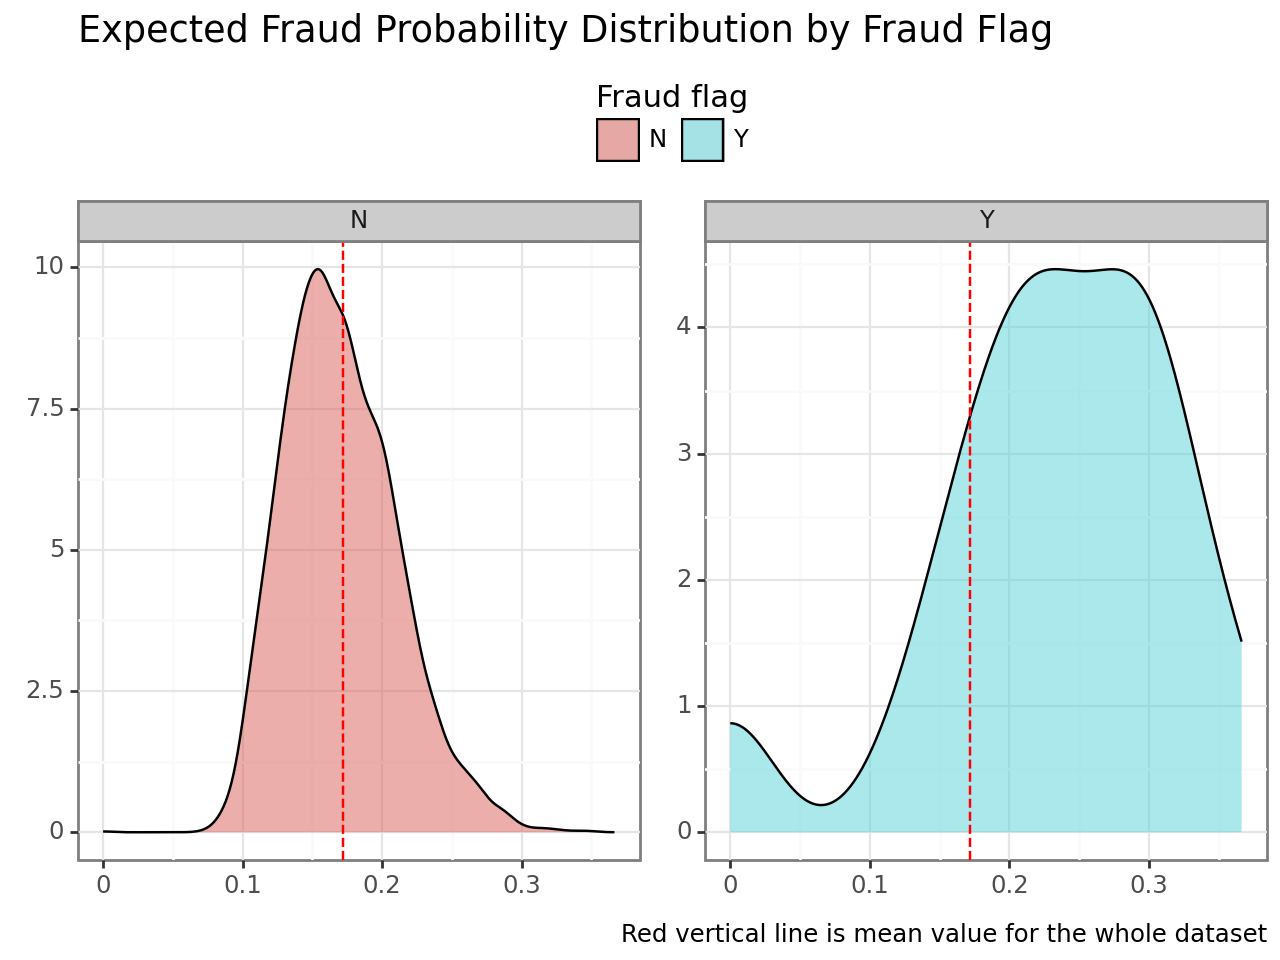

<Figure Size: (640 x 480)>

In [12]:
(
    ggplot(training_set, aes(x="expected_fraud_probability", fill="fraud_flag"))
    + geom_density(alpha=0.5)
    + facet_wrap("~ fraud_flag", scales="free_y")
    + theme_bw()
    + labs(
        title="Expected Fraud Probability Distribution by Fraud Flag",
        x="",
        y="",
        fill="Fraud flag",
        caption="Red vertical line is mean value for the whole dataset",
    )
    + theme(legend_position="top")
    + geom_vline(
        xintercept=training_set["expected_fraud_probability"].mean(),
        color="red",
        linetype="dashed",
        size=0.5,
    )
)

This looks promissing: the distribution of the `expected_fraud_probability` is different for fraud and non-fraud transactions, it is shifted to the right for fraud transactions.

It could indicate that model that contains the information that could help to identify the fraud. 

### Model Standard Deviation Flags

In [21]:
print("Mean of sd_flags: ", training_set["sd_flags"].mean().round(2))

Mean of sd_flags:  1.4


C:\Users\mateu\miniconda3\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


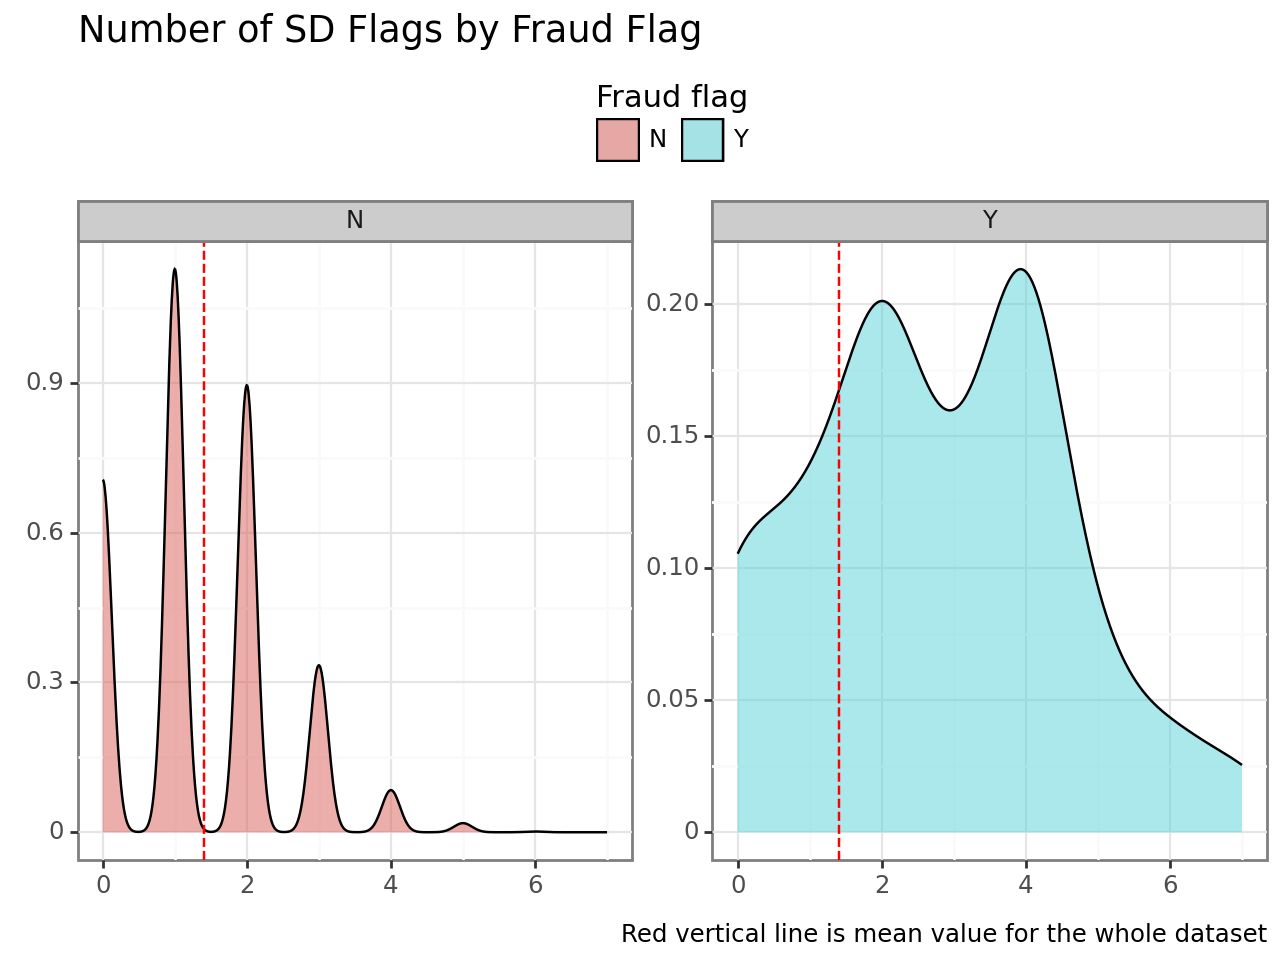

<Figure Size: (640 x 480)>

In [22]:
(
    ggplot(training_set, aes(x="sd_flags", fill="fraud_flag"))
    + geom_density(alpha=0.5)
    + facet_wrap("~ fraud_flag", scales="free_y")
    + theme_bw()
    + labs(
        title="Number of SD Flags by Fraud Flag",
        x="",
        y="",
        fill="Fraud flag",
        caption="Red vertical line is mean value for the whole dataset",
    )
    + theme(legend_position="top", subplots_adjust={"wspace": 0.25})
    + geom_vline(
        xintercept=training_set["sd_flags"].mean(),
        color="red",
        linetype="dashed",
        size=0.5,
    )
)

This may serve as a significant indicator. It suggests that the likelihood of detecting fraud increases as more flags are identified in an observation.

### Quantile Flags

In [51]:
print("Mean of quantile flags: ", training_set["quantile_flags"].mean().round(2))

Mean of quantile flags:  1.75


c:\Users\Mateusz\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\facets\facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


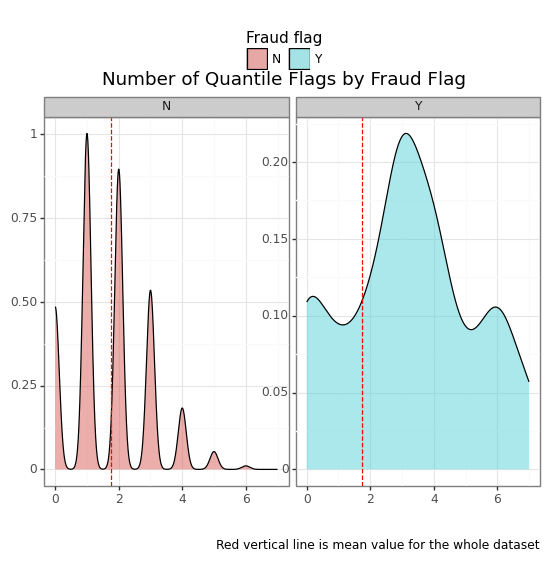

<ggplot: (168221518653)>

In [52]:
(
    ggplot(training_set, aes(x="quantile_flags", fill="fraud_flag"))
    + geom_density(alpha=0.5)
    + facet_wrap("~ fraud_flag", scales="free_y")
    + theme_bw()
    + labs(
        title="Number of Quantile Flags by Fraud Flag",
        x="",
        y="",
        fill="Fraud flag",
        caption="Red vertical line is mean value for the whole dataset",
    )
    + theme(legend_position="top")
    + geom_vline(
        xintercept=training_set["quantile_flags"].mean(),
        color="red",
        linetype="dashed",
        size=0.5,
    )
)

This may serve as a significant indicator. It suggests that the likelihood of detecting fraud increases as more flags are identified in an observation.

### Model Fraud thresholds
1. expected_fraud_probability
2. sd_flags
3. quantile_flags

In [13]:
result = joined_data_aggregated.assign(
    predicted_fraud=np.where(
        (joined_data_aggregated["expected_fraud_probability"] > 0.15)
        & (joined_data_aggregated["sd_flags"] > 1)
        & (joined_data_aggregated["quantile_flags"] > 1)
        & (joined_data_aggregated["quantile_9_flags"] > 2),
        1,
        0,
    )
)

### Train Model Evaluation

In [14]:
train_model = X_train[["timestamp", "customer", "counterparty", "fraud_flag"]].merge(
    result.drop(columns="fraud_flag"),
    on=["timestamp", "customer", "counterparty"],
    how="left",
)

train_model_prediction = train_model.groupby(["fraud_flag", "predicted_fraud"]).agg(
    mean_value=("expected_fraud_probability", "mean"),
    q1_value=("expected_fraud_probability", lambda x: x.quantile(0.1)),
    q25_value=("expected_fraud_probability", lambda x: x.quantile(0.25)),
    q75_value=("expected_fraud_probability", lambda x: x.quantile(0.75)),
    q9_value=("expected_fraud_probability", lambda x: x.quantile(0.9)),
    sd_flags=("sd_flags", "sum"),
    quantile_flags=("quantile_flags", "sum"),
    quantile_1_flags=("quantile_1_flags", "sum"),
    quantile_25_flags=("quantile_25_flags", "sum"),
    quantile_75_flags=("quantile_75_flags", "sum"),
    quantile_9_flags=("quantile_9_flags", "sum"),
    n=("expected_fraud_probability", "count"),
)
train_model_prediction["sd_mean_flags"] = (
    train_model_prediction["sd_flags"] / train_model_prediction["n"]
)
train_model_prediction["quantile_mean_flags"] = (
    train_model_prediction["quantile_flags"] / train_model_prediction["n"]
)

train_model_prediction["quantile_1_mean_flags"] = (
    train_model_prediction["quantile_1_flags"] / train_model_prediction["n"]
)

train_model_prediction["quantile_25_mean_flags"] = (
    train_model_prediction["quantile_25_flags"] / train_model_prediction["n"]
)

train_model_prediction["quantile_75_mean_flags"] = (
    train_model_prediction["quantile_75_flags"] / train_model_prediction["n"]
)

train_model_prediction["quantile_9_mean_flags"] = (
    train_model_prediction["quantile_9_flags"] / train_model_prediction["n"]
)
train_model_prediction = train_model_prediction.reset_index()

train_model_eval = train_model.assign(
    fraud_flag_transformed=np.where((train_model["fraud_flag"] == "Y"), 1, 0)
).dropna()

In [15]:
train_model_prediction

,fraud_flag,predicted_fraud,mean_value,q1_value,q25_value,q75_value,q9_value,sd_flags,quantile_flags,quantile_1_flags,quantile_25_flags,quantile_75_flags,quantile_9_flags,n,sd_mean_flags,quantile_mean_flags,quantile_1_mean_flags,quantile_25_mean_flags,quantile_75_mean_flags,quantile_9_mean_flags
0,N,0,0.157437,0.117346,0.134650,0.178415,0.200701,3140.0,3907.0,25747.0,22355.0,6649.0,3907.0,3219,0.975458,1.213731,7.998447,6.944703,2.065548,1.213731
1,N,1,0.214645,0.173553,0.190816,0.234872,0.261790,2610.0,3297.0,8445.0,7770.0,4125.0,3297.0,956,2.730126,3.448745,8.833682,8.127615,4.314854,3.448745
2,Y,0,0.071808,0.000000,0.000000,0.164125,0.201514,26.0,28.0,184.0,162.0,45.0,28.0,52,0.500000,0.538462,3.538462,3.115385,0.865385,0.538462
3,Y,1,0.293995,0.219831,0.256903,0.341965,0.366561,250.0,280.0,550.0,540.0,355.0,280.0,58,4.310345,4.827586,9.482759,9.310345,6.120690,4.827586


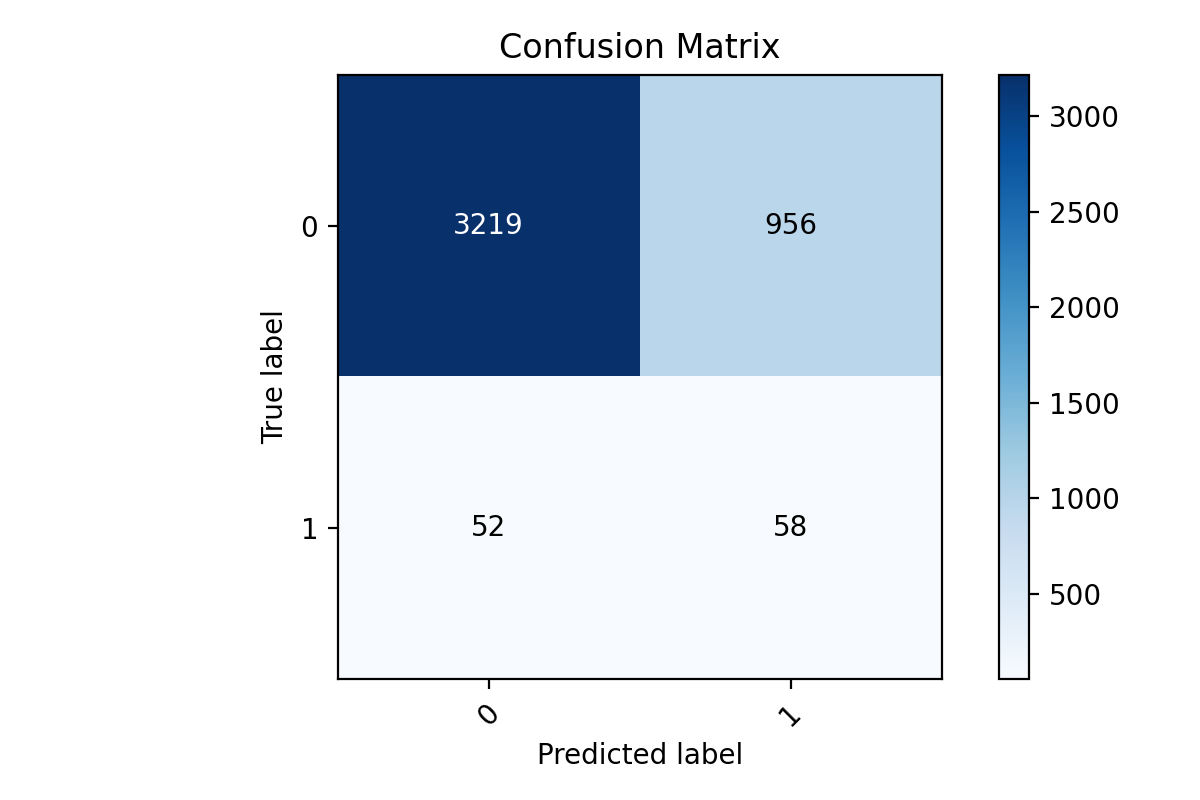


Accuracy: 76.48% 

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      4175
           1       0.06      0.53      0.10       110

    accuracy                           0.76      4285
   macro avg       0.52      0.65      0.48      4285
weighted avg       0.96      0.76      0.85      4285



In [16]:
evaluateModel(
    train_model_eval["fraud_flag_transformed"], train_model_eval["predicted_fraud"]
)

### Predictive Model Definition
1. Join and transform the data
    - Prediction Input Data
    - Dictionaries
    - Meta Dictionary
2. Definie Model Formula by adding the thresholds as in `Training Model setup - Model Fraud thresholds` section
3. Compare prediction set fraud probability with Meta Dictionary thresholds for standard deviation and quantile flags

In [72]:
joined_data_test = (
    X_test.merge(dictionaries["customer_country"], on="customer_country", how="left")
    .merge(dictionaries["counterparty_country"], on="counterparty_country", how="left")
    .merge(dictionaries["type"], on="type", how="left")
    .merge(dictionaries["ccy"], on="ccy", how="left")
    .merge(dictionaries["customer_type"], on="customer_type", how="left")
    .merge(dictionaries["weekday"], on="weekday", how="left")
    .merge(dictionaries["month"], on="month", how="left")
    .merge(dictionaries["quarter"], on="quarter", how="left")
    .merge(dictionaries["hour"], on="hour", how="left")
    .merge(dictionaries["amount_eur_bucket"], on="amount_eur_bucket", how="left")
    .loc[
        :,
        [
            "timestamp",
            "customer",
            "customer_country",
            "customer_type",
            "counterparty",
            "counterparty_country",
            "type",
            "ccy",
            "amount_eur_bucket",
            "weekday",
            "month",
            "quarter",
            "hour",
            "customer_country_value",
            "counterparty_country_value",
            "type_value",
            "ccy_value",
            "customer_type_value",
            "weekday_value",
            "month_value",
            "quarter_value",
            "hour_value",
            "amount_eur_bucket_value",
        ],
    ]
)

joined_data_test = (
    joined_data_test.melt(
        id_vars=[
            "timestamp",
            "customer",
            "counterparty",
            "customer_country",
            "counterparty_country",
            "type",
            "ccy",
            "amount_eur_bucket",
            "weekday",
            "month",
            "quarter",
            "hour",
            "customer_type",
        ],
        value_vars=[
            "customer_country_value",
            "counterparty_country_value",
            "type_value",
            "ccy_value",
            "customer_type_value",
            "weekday_value",
            "month_value",
            "quarter_value",
            "hour_value",
            "amount_eur_bucket_value",
        ],
    )
    .assign(name=lambda x: x["variable"].str.replace("_value", ""))
    .merge(meta_dictionary, left_on="name", right_on="variable_name")
    .drop(columns=["variable_name", "variable"])
)

joined_data_test_aggregated = (
    joined_data_test.assign(sd_flag=lambda x: np.where(x["value"] > x["sd_flag"], 1, 0))
    .assign(quantile_flag=lambda x: np.where(x["value"] > x["q_flag"], 1, 0))
    .assign(quantile_1_flag=lambda x: np.where(x["value"] > x["q_1_flag"], 1, 0))
    .assign(quantile_25_flag=lambda x: np.where(x["value"] > x["q_25_flag"], 1, 0))
    .assign(quantile_75_flag=lambda x: np.where(x["value"] > x["q_75_flag"], 1, 0))
    .assign(quantile_9_flag=lambda x: np.where(x["value"] > x["q_9_flag"], 1, 0))
    .drop_duplicates(["timestamp", "customer", "counterparty", "name"])
    .groupby(
        [
            "timestamp",
            "customer",
            "counterparty",
            "customer_country",
            "counterparty_country",
            "type",
            "ccy",
            "amount_eur_bucket",
            "weekday",
            "month",
            "quarter",
            "hour",
            "customer_type",
        ]
    )
    .agg(
        expected_fraud_probability=("value", "sum"),
        sd_flags=("sd_flag", "sum"),
        quantile_flags=("quantile_flag", "sum"),
        quantile_1_flags=("quantile_1_flag", "sum"),
        quantile_25_flags=("quantile_25_flag", "sum"),
        quantile_75_flags=("quantile_75_flag", "sum"),
        quantile_9_flags=("quantile_9_flag", "sum"),
    )
    .reset_index()
)

model_formula = joined_data_test_aggregated.assign(
    predicted_fraud=np.where(
        (joined_data_test_aggregated["expected_fraud_probability"] > 0.18)
        & (joined_data_test_aggregated["sd_flags"] > 1)
        & (joined_data_test_aggregated["quantile_flags"] > 1),
        1,
        0,
    )
)

joined_data_aggregated = X_test[
    [
        "timestamp",
        "customer",
        "counterparty",
        "customer_country",
        "counterparty_country",
        "type",
        "ccy",
        "amount_eur_bucket",
        "fraud_flag",
        "weekday",
        "month",
        "quarter",
        "hour",
        "customer_type",
    ]
].merge(
    model_formula,
    on=[
        "timestamp",
        "customer",
        "counterparty",
        "customer_country",
        "counterparty_country",
        "type",
        "ccy",
        "amount_eur_bucket",
        "weekday",
        "month",
        "quarter",
        "hour",
        "customer_type",
    ],
    how="left",
)

joined_data_aggregated = joined_data_aggregated.assign(
    fraud_flag_transformed=np.where((joined_data_aggregated["fraud_flag"] == "Y"), 1, 0)
).fillna(0)

test_model = joined_data_aggregated

### Prediction Model Evaulation

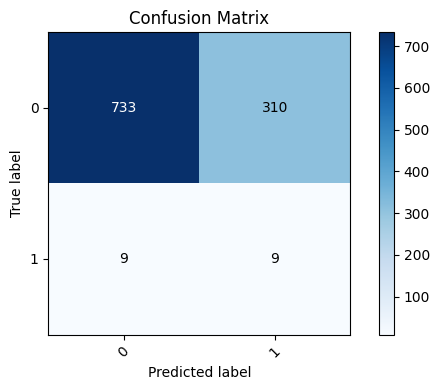


Accuracy: 69.93% 

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1043
           1       0.03      0.50      0.05        18

    accuracy                           0.70      1061
   macro avg       0.51      0.60      0.44      1061
weighted avg       0.97      0.70      0.81      1061



In [73]:
evaluateModel(test_model["fraud_flag_transformed"], test_model["predicted_fraud"])

In [74]:
test_model_prediction = test_model.groupby(["fraud_flag", "predicted_fraud"]).agg(
    mean_value=("expected_fraud_probability", "mean"),
    q1_value=("expected_fraud_probability", lambda x: x.quantile(0.1)),
    q25_value=("expected_fraud_probability", lambda x: x.quantile(0.25)),
    q75_value=("expected_fraud_probability", lambda x: x.quantile(0.75)),
    q9_value=("expected_fraud_probability", lambda x: x.quantile(0.9)),
    sd_flags=("sd_flags", "sum"),
    quantile_flags=("quantile_flags", "sum"),
    quantile_1_flags=("quantile_1_flags", "sum"),
    quantile_25_flags=("quantile_25_flags", "sum"),
    quantile_75_flags=("quantile_75_flags", "sum"),
    quantile_9_flags=("quantile_9_flags", "sum"),
    n=("expected_fraud_probability", "count"),
)
test_model_prediction["sd_mean_flags"] = (
    test_model_prediction["sd_flags"] / test_model_prediction["n"]
)
test_model_prediction["quantile_mean_flags"] = (
    test_model_prediction["quantile_flags"] / test_model_prediction["n"]
)

test_model_prediction["quantile_1_mean_flags"] = (
    test_model_prediction["quantile_1_flags"] / test_model_prediction["n"]
)

test_model_prediction["quantile_25_mean_flags"] = (
    test_model_prediction["quantile_25_flags"] / test_model_prediction["n"]
)

test_model_prediction["quantile_75_mean_flags"] = (
    test_model_prediction["quantile_75_flags"] / test_model_prediction["n"]
)

test_model_prediction["quantile_9_mean_flags"] = (
    test_model_prediction["quantile_9_flags"] / test_model_prediction["n"]
)
test_model_prediction = test_model_prediction.reset_index()

test_model_prediction

,fraud_flag,predicted_fraud,mean_value,q1_value,q25_value,q75_value,q9_value,sd_flags,quantile_flags,quantile_1_flags,quantile_25_flags,quantile_75_flags,quantile_9_flags,n,sd_mean_flags,quantile_mean_flags,quantile_1_mean_flags,quantile_25_mean_flags,quantile_75_mean_flags,quantile_9_mean_flags
0,N,0.0,0.153860,0.121005,0.137736,0.171302,0.183029,669.0,909.0,5898.0,5115.0,1495.0,909.0,733,0.912688,1.240109,8.046385,6.978172,2.039563,1.240109
1,N,1.0,0.220274,0.188503,0.198196,0.234832,0.260513,819.0,944.0,2750.0,2546.0,1262.0,944.0,310,2.641935,3.045161,8.870968,8.212903,4.070968,3.045161
2,Y,0.0,0.141442,0.106429,0.139275,0.177135,0.182443,6.0,12.0,71.0,63.0,17.0,12.0,9,0.666667,1.333333,7.888889,7.000000,1.888889,1.333333
3,Y,1.0,0.265827,0.203720,0.223016,0.297271,0.324805,33.0,37.0,83.0,77.0,49.0,37.0,9,3.666667,4.111111,9.222222,8.555556,5.444444,4.111111


### Comparative Performance with Tree-Based Models

- The model is noted for identifying more Positives compared to tree-based models.
- The overall accuracy being lower than tree-based models.

### Potential for Improvement

- Thresholds fine-tuning. 
- Integrating the model with Reinforcement Learning. This could allow the model to adaptively learn and update its parameters based on feedback, which could be particularly useful in dynamic environments like fraud detection.
- Updating dictionary values when the model makes incorrect predictions is an example of a feedback mechanism that could improve the model's performance over time.

### Combining Models for Robustness

- Dictionary-based model could be used as a Feature Engineering tool providing additional data for ML models. 